# Business Understanding (10 points total).  
[10 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). Why is this data important and how will you know if you have gathered useful knowledge from the dataset? Be specific and use your own words to describe the aspects of the data.

The dataset is a collection of handwritten digits taken from American Census Beareau employees. The data was collected by the NIST (National Institute of Science and Technology) and is a subset of their training data. The data comes from a larger database called the MNIST (Mixed National Institute of Science and Technology) database. The database is split into two datasets, a training and a testing. This dataset used in this project is a subset of size 60,000 images that are each 28x28 pixels.

This data is downloaded from:
http://yann.lecun.com/exdb/mnist/

The purpose of the data set was to classify numbers. The NIST trained the dataset on digits written by American Census Beareau employees and then tested the set on digits written by highschoolers. After they did this, the dataset became somewhat famous and is a widely used machine learning sample dataset.

This data is important because the classification of written digits can be useful. To list a couple of examples, reading credit cards, standardized test grading, written text to digital text conversion, etc. A more interesting importance of the data is to do a typographic study on what features of digits make it more difficult to differentiate between different digits and which features tell us more about what the digit is. This could help us design better typographic fonts for readability, or maybe even redefine standards on how digits should be written.

We know that we have gathered useful data if we are:   
    a) able to split the digits into a set of features
    b) able to classify digits correctly
    c) able to rank features from highest to lowest importance

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.misc import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import warnings
import seaborn as sns
import gzip
from struct import unpack
import warnings
from ipywidgets import widgets  # make this interactive!

%matplotlib inline

# Data Preparation (20 points total)
[5 points] Read in your images data as numpy arrays. Resize and recolor images as necessary. 

#### Read in data

Data is given as a gzipped binary file in the following format

[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
0017     unsigned byte   ??               pixel
........
xxxx     unsigned byte   ??               pixel

Labels are given as a gzipped binary file in the following format

[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
0009     unsigned byte   ??               label
........
xxxx     unsigned byte   ??               label
The labels values are 0 to 9.

In [2]:
binaryData = gzip.open('train-images-idx3-ubyte.gz', 'rb')
binaryLabels = gzip.open('train-labels-idx1-ubyte.gz', 'rb')

# Get metadata for images
# magic number means nothing to me so skip
binaryData.read(4)
binaryLabels.read(8)
numImages = binaryData.read(4)
numImages = unpack('>I', numImages)[0]
numImages = numImages - 55000
# Interpret packed binary data as '>I' which is big endian unsigned int
numRows = binaryData.read(4)
numRows = unpack('>I', numRows)[0]
numCols = binaryData.read(4)
numCols = unpack('>I', numCols)[0]

print(numImages) # should be 5000

# Now read into numpy array
images = np.empty([numImages, numRows, numCols], dtype=np.float32) 
labels = np.empty([numImages, 1], dtype=np.uint8)
for image in range(numImages):
    for row in range(numRows):
        for col in range(numCols):
                pixel = binaryData.read(1)  # Just a single byte
                pixel = unpack('>B', pixel)[0]
                images[image][row][col] = pixel
    label = binaryLabels.read(1)
    labels[image] = unpack('>B', label)[0]
print('done')

5000
done


The data set is an extremely famous dataset that has been used many times. I doubt that the data needs to be cleaned. I know the images do not need to be resized as they have been standardized to a 28x28 pixel image. We are just using a subset of the images to make things faster. 60,000 down to 5,000 images.

[10 points] Linearize the images to create a table of 1-D image features (each row should be one image).  

#### Create bag of pixels model

In [3]:
# get some of the specifics of the dataset
counter = 0
X = np.empty([numImages, numRows * numCols])
for image in images:
    X[counter] = image.flatten()
    counter= counter + 1

So basically each feature vector is a giant image with the rows of the image just stacked one after the other into a giant vector. We create this model by doing what I described in the previous sentence using the flatten() function which takes a multiple dimension matrix and flattens it into a vector.

This is extremely similar to our bag of words model, where each word was considered a feature. Hence why I like bag of pixels model, because it seems like a more intuitive description to me.

In [4]:
n_samples, n_features = X.shape
_, h, w = images.shape
n_classes = len(labels)

print("n_samples: {}".format(n_samples))
print("n_features: {}".format(n_features))
print("n_classes: {}".format(n_classes))
print("Original Image Sizes {} by {}".format(h,w))

n_samples: 5000
n_features: 784
n_classes: 5000
Original Image Sizes 28 by 28


[5 points] Visualize several images.

#### Print several images

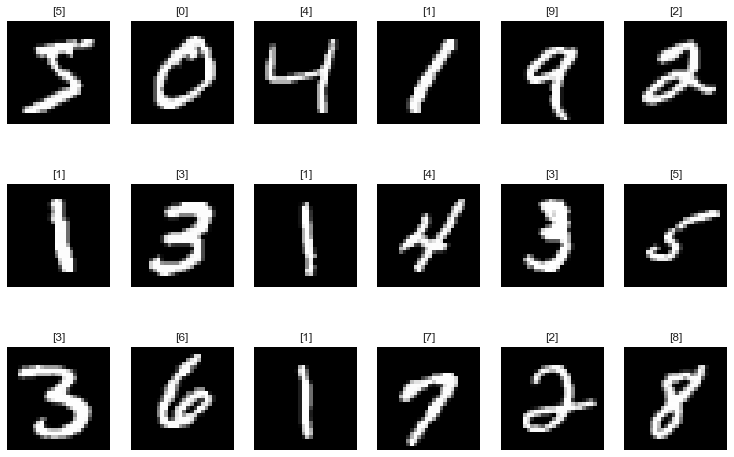

In [5]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(images, labels, h, w)
plt.show() # need for python 3

Images look correct. From a human perspective, they seem very easily classified.

# Data Reduction (60 points total)
[10 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. How many dimensions are required to adequately represent your image data?

In [6]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image 

In [7]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

In [8]:
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenobjects from %d objects" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)

Extracting the top 300 eigenobjects from 5000 objects
Wall time: 1.52 s


PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [9]:
plot_explained_variance(pca)

We performed a dimension reduction using PCA with 300 components. The number of principal components needed to accurately represent the image data varies. It really depends on how accurate you need the representation to be.

Generally I would say that you want to explain at least 95% of the variance, so I'd say above 150 principal components would be a good limit.

This really surprised me, as I thought the dataset was extremely simple and the number of principal components required was large.

## Full PCA

In [10]:
from sklearn.decomposition import PCA

n_components = 150
print ("Extracting the top %d eigenobjects from %d objects" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X)
images_pca_ev = pca.components_.reshape((n_components, h, w))

Extracting the top 150 eigenobjects from 5000 objects
Wall time: 741 ms


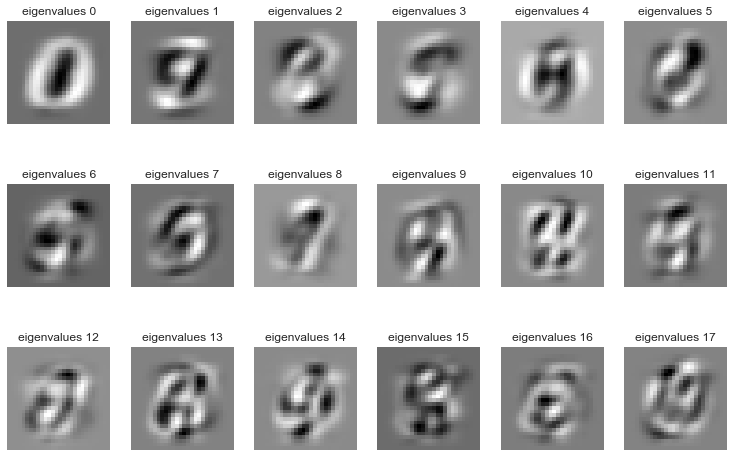

In [11]:
image_titles = ["eigenvalues %d" % i for i in range(images_pca_ev.shape[0])]
plot_gallery(images_pca_ev, image_titles, h, w)

We can tell alot about our dataset from our eigenvalues. We can sort of find numbers and the semblence of the features of the numbers inside many of the eigenvalues. (Eigenvalue 0 looks like a 0, eigenvalue 12 looks like a 8, etc.)

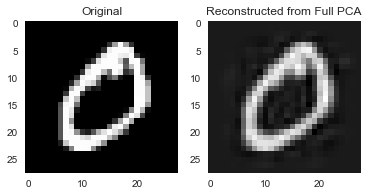

In [12]:
warnings.simplefilter('ignore', DeprecationWarning)

idx_to_reconstruct = 1
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X[idx_to_reconstruct])

plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid()
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid()
plt.show()

We can see that there is little loss in this example of PCA. The reconstruction seems a little blurrier, but is still clearly distinguishable as the digit 0.

[10 points] Perform non-linear dimensionality reduction of your image data. Compare the representation using non-linear dimensions to using linear dimensions. Do you prefer one method over another? Why?

# Kernel PCA

In [13]:
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigenobjects from %d objects" % (n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                 fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(X)

Extracting the top 300 eigenobjects from 5000 objects
Wall time: 37 s


KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=True, gamma=15, kernel='rbf',
     kernel_params=None, max_iter=None, n_components=300, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)

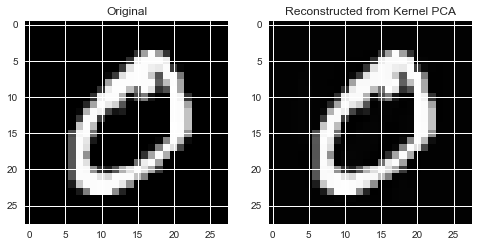

In [56]:
warnings.simplefilter('ignore', DeprecationWarning)

idx_to_reconstruct = 1
low_dimensional_representation, reconstructed_image = reconstruct_image(kpca,X[idx_to_reconstruct])

plt.subplot(1,2,1)
plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Kernel PCA')
plt.show()

The Kernel PCA looks just about the same as the original image.

#### Comparison between Full PCA and Kernel PCA

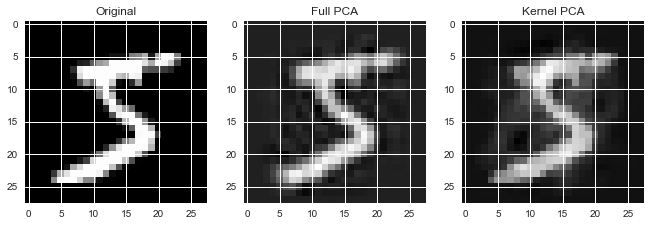

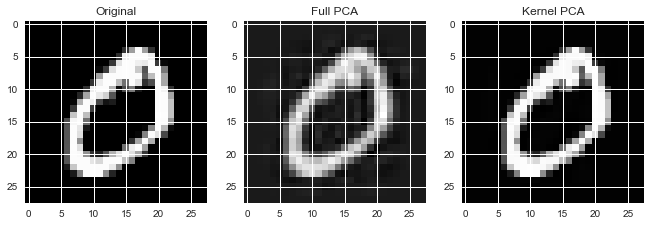

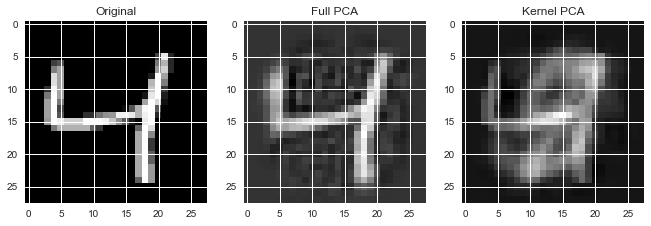

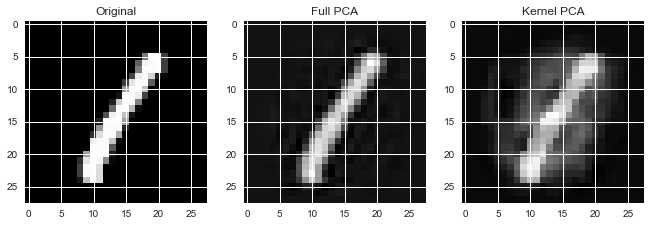

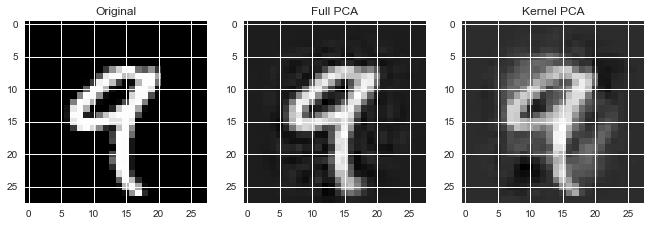

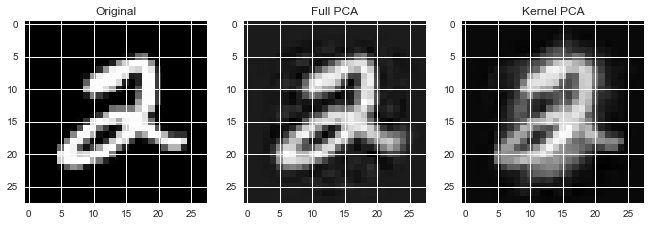

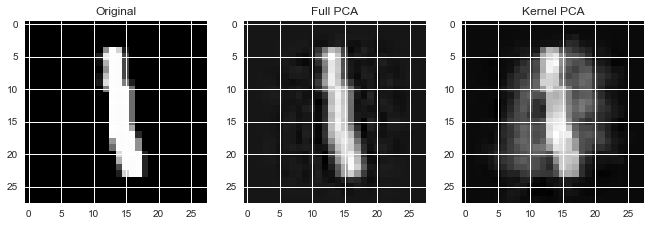

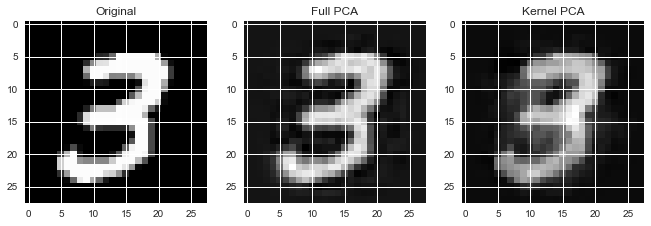

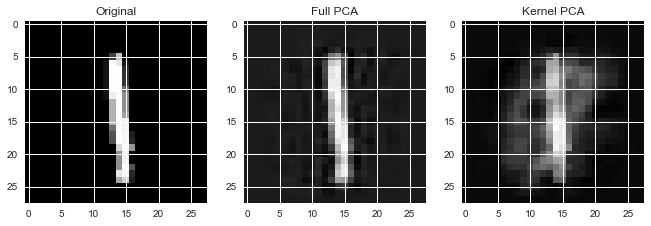

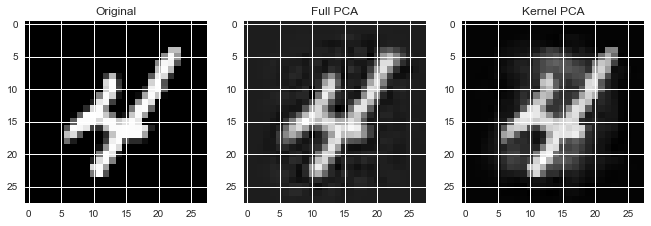

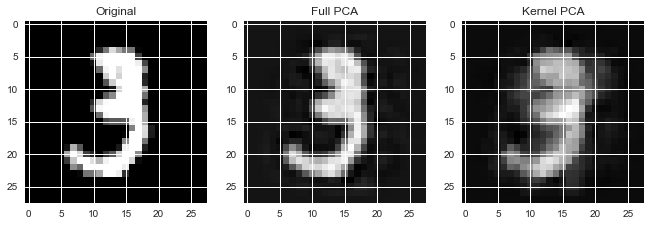

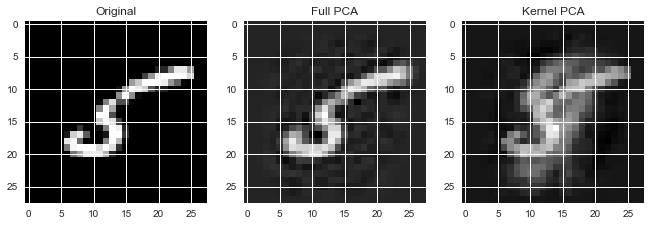

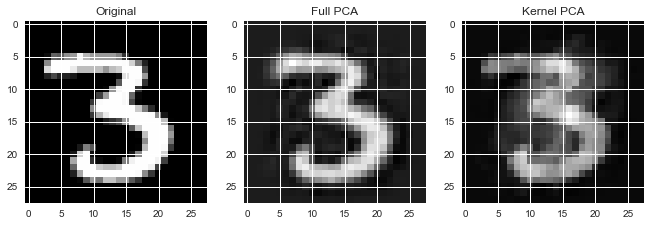

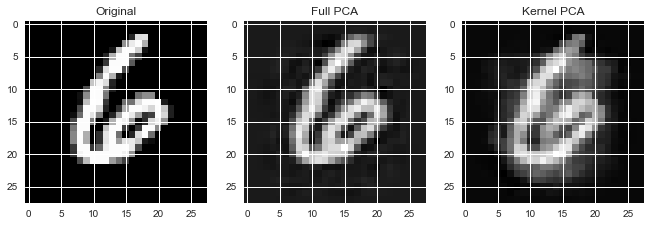

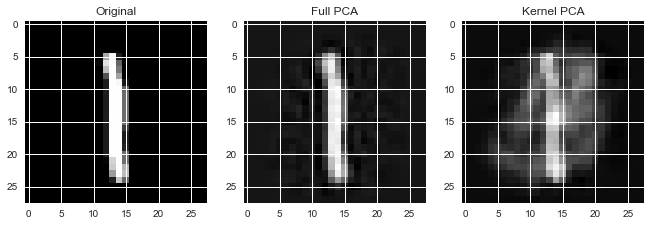

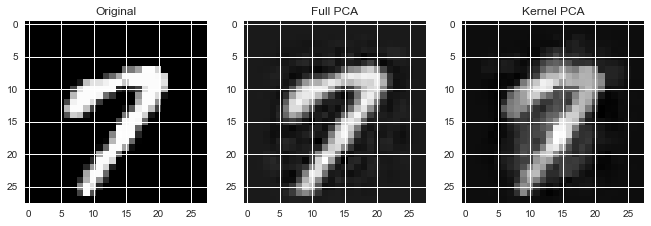

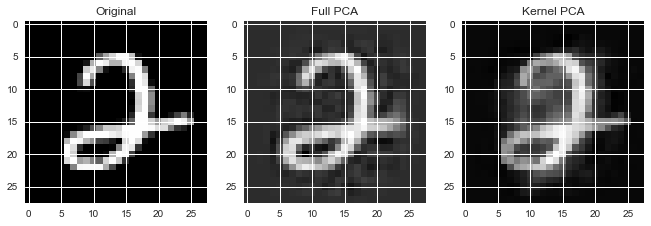

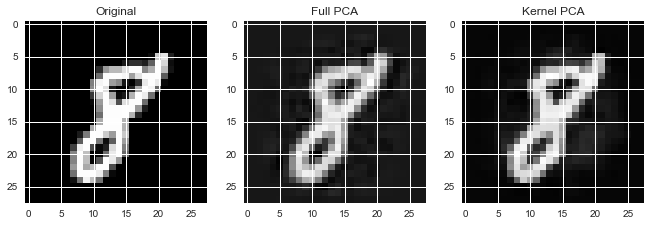

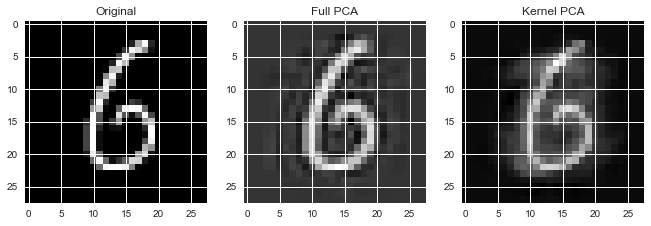

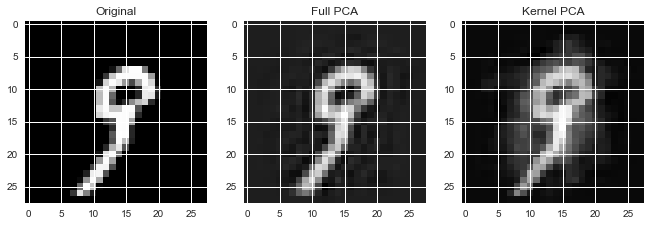

In [15]:
warnings.simplefilter('ignore', DeprecationWarning)

# compare the different methods
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Original')
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Full PCA')
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_kpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.show()
    
for i in range(0,20):
    plt_reconstruct(i)

We compared the first 20 images in our dataset. 

We saw that although kernel PCA performed well on most of the data, there are cases where the kernel PCA is completely wrong. 

In this data set, kernel PCA is usually not as accurate as full PCA.

We decided that full PCA was a better representation of the true image. Only 10% of images had a better kernel PCA case.


[20 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, etc.).

# Gabor Filters


In [16]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, (h,w))
gabr_feature

array([  2.88025819e+01,   2.83361308e+03,   1.79534144e+00,
         1.85199833e+00,   8.80510481e+00,   5.04133304e+02,
         2.30511082e+00,   4.41689361e+00,   1.94292944e+01,
         6.27155544e+02,   1.21778204e+00,   3.88309290e-01,
         2.89813009e-02,   2.22250046e+01,   1.03512953e-01,
         5.64794021e+00,   2.88028374e+01,   2.82670884e+03,
         1.79383996e+00,   1.85071289e+00,   8.81744064e+00,
         4.81345318e+02,   2.30792324e+00,   4.53791227e+00,
         1.95975521e+01,   6.18517577e+02,   1.42979294e+00,
         1.28827300e+00,   4.66781242e-03,   2.90614313e+01,
         4.75391742e-02,   6.29610079e+00,   2.88025819e+01,
         2.82351028e+03,   1.79044567e+00,   1.83173655e+00,
         8.80510481e+00,   4.47471873e+02,   2.22640939e+00,
         4.10102442e+00,   1.94292944e+01,   5.84862260e+02,
         1.25561250e+00,   5.98698811e-01,   2.89813009e-02,
         1.62626594e+01,   1.03255532e-01,   4.46261038e+00,
         2.88028374e+01,

In [17]:
# takes ~3 minutes to run entire dataset
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (h,w))
print(gabor_stats.shape)

Wall time: 1min 56s
(5000, 64)


In [18]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(gabor_stats,n_jobs=-1)

Wall time: 3.03 s


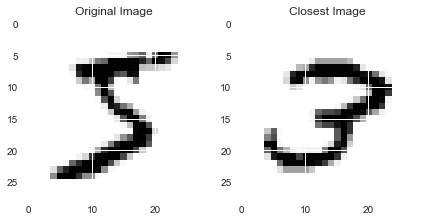

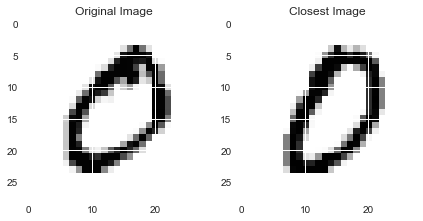

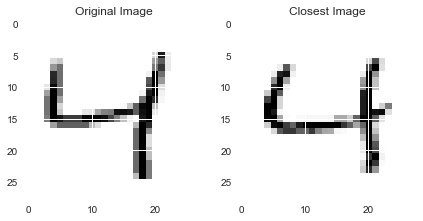

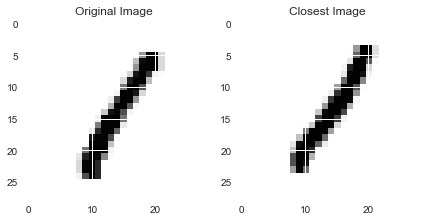

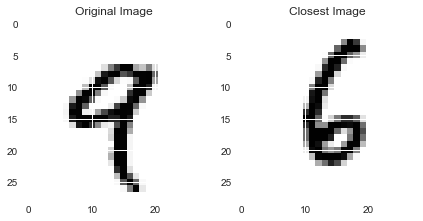

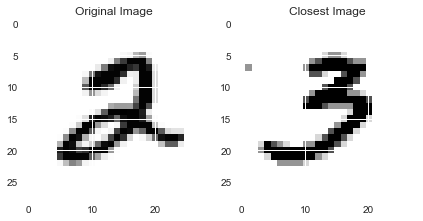

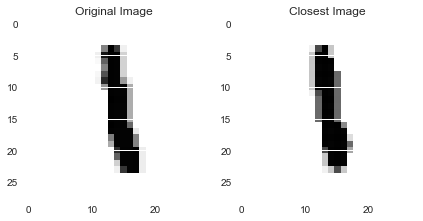

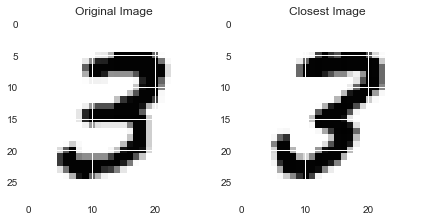

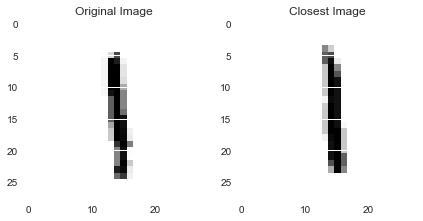

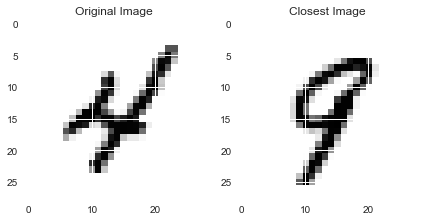

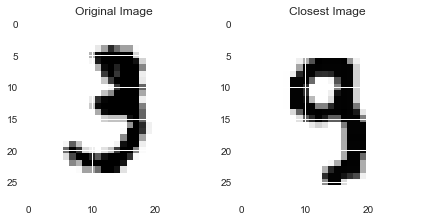

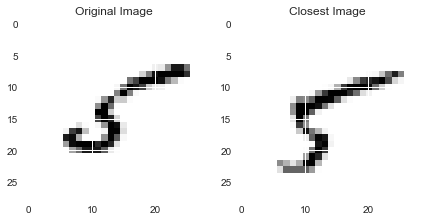

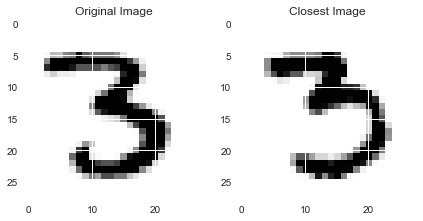

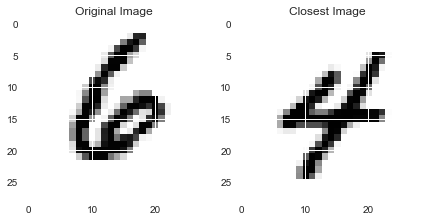

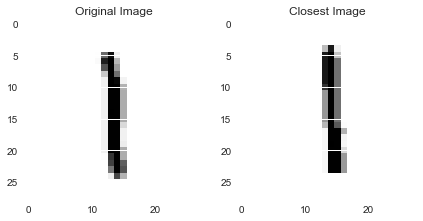

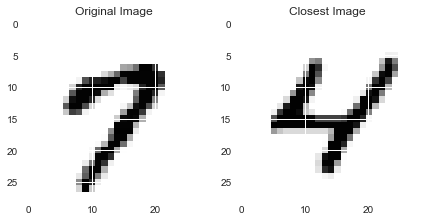

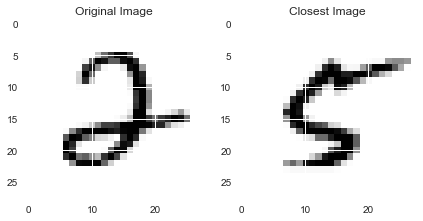

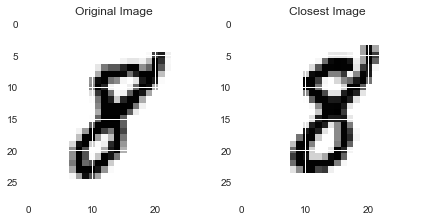

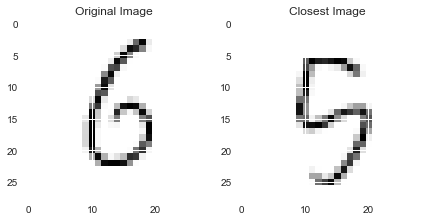

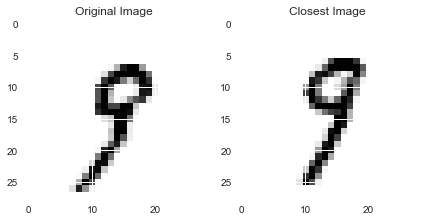

In [53]:
import copy
# find closest image to current image

for i in range(0,20):
    idx1 = i
    distances = copy.deepcopy(dist_matrix[idx1,:])
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)

    plt.figure(figsize=(7,10))
    plt.subplot(1,2,1)
    plt.imshow(X[idx1].reshape((h,w)))
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(X[idx2].reshape((h,w)))
    plt.title("Closest Image")

    plt.show()

The Gabor filters only had a 55% accuracy rate using the first 20 images in our dataset.

We can see that the Gabor filter does an alright job pairing closest images with the same label correctly, however, it does not do as good of a job as Kernel PCA or Full PCA in this dataset.

This makes sense as the Gabor filter is traditionally used to detect textures and edges, and in numbers, the slant of somebodies handwriting and different sections of different numbers can look similar which can throw off the classification. 

For example on the 5th image the Gabor filters thought that the up and down part on the 9 was similar to the up and down part of the number 6. This was due to the fact that whoever wrote the 9 curved his up and down section.

In [20]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(gabor_stats)

Wall time: 690 ms


[20 points] Visualize the differences between instances in each target class. For example, a heat map of the pairwise differences among all instances is likely appropriate for your data. Do you think the features extracted are appropriate for classification on your dataset? 

# Comparing Gabor Filters

In [37]:
cols = np.arange(0, 66, 1)
col_vector = np.array(labels)
cols_test = np.column_stack((col_vector,col_vector))
gabor = np.hstack((gabor_stats, cols_test))
df = pd.DataFrame(gabor, columns=cols)
df.head()

0            1         2         3          4           5   \
0  33.405995  3427.621939  1.718405  1.623617  10.212393  461.444776   
1  37.738761  3833.707795  1.504230  0.830680  11.536943  676.496480   
2  23.597194  1986.633402  1.932433  2.524085   7.213790  494.515182   
3  20.796066  2541.914221  2.562178  5.359308   6.357470  453.659810   
4  28.173906  2907.524224  1.856440  2.068649   8.612915  532.777212   

         6         7          8           9  ...          56          57  \
0  1.979200  2.769121  22.534608  649.422193 ...   22.729758  613.724544   
1  1.917259  2.497745  25.457353  732.111836 ...   25.677814  688.945517   
2  2.710600  7.047294  15.917907  378.089050 ...   16.055756  331.631997   
3  2.940555  7.395235  14.028357  562.250577 ...   14.149842  394.304567   
4  2.478354  5.255722  19.005210  711.965697 ...   19.169795  655.748873   

         58        59        60         61        62        63   64   65  
0  0.931668 -0.378288  0.005414  33.395501  0.112164  6.216305  5.0  5.0  
1  0.811120 -0.383980  0.006116   9.330763  0.032664  5.067246  0.0  0.0  
2  0.972531 -0.281946  0.003824   4.589393  0.069834  3.135029  4.0  4.0  
3  1.326749  0.443221  0.003370   4.603865  0.075996  5.700528  1.0  1.0  
4  1.189956  0.057405  0.004566  10.978836  0.143749  6.924321  9.0  9.0  

[5 rows x 66 columns]

Just getting an idea of what the Gabor matrix looks like.

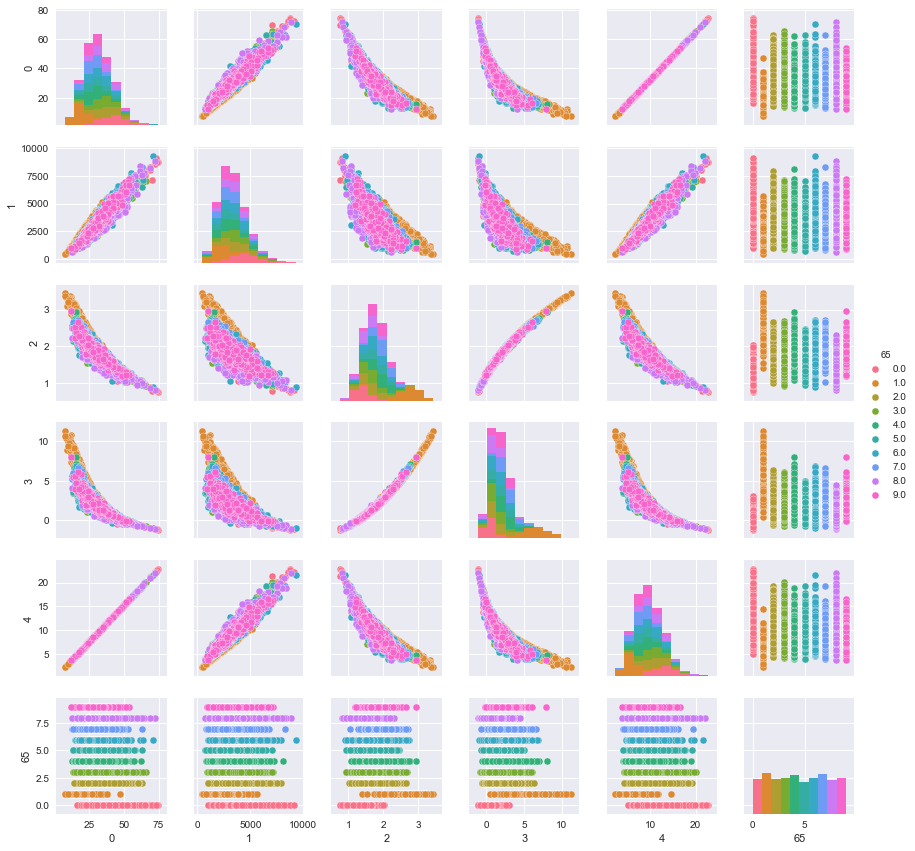

In [38]:
deleted_cols = np.arange(5,65,1)
df.drop(df.columns[deleted_cols], axis=1, inplace=True)
df.head()
sns.set()
sns.pairplot(df,hue=65, size=2)

The pairplot above shows the top 5 Gabor features for the classes 0-9. It is hard to tell what is what because there are so many values in a certain area. Generally the only number that has some difference from the rest is the number 1. The number 1 is the most basic number and is the most different from the rest of the numbers. All of the other classes overlap each other pretty much.

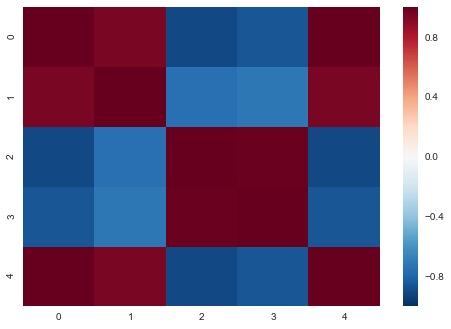

In [39]:
cols = np.arange(0,64,1)
df_no_labels = pd.DataFrame(gabor_stats, columns=cols)
deleted_cols = np.arange(5,64,1)

df_no_labels.drop(df_no_labels.columns[deleted_cols], axis=1, inplace=True)
sns.heatmap(df_no_labels.corr())

We can see from this heat map that there is a high and low correlation between different gabor values. There is no between. Since the Gabor filters are applied at different orientations we get this difference in the heat map. One orientation gives a higher correlation and the other gives no correlation.

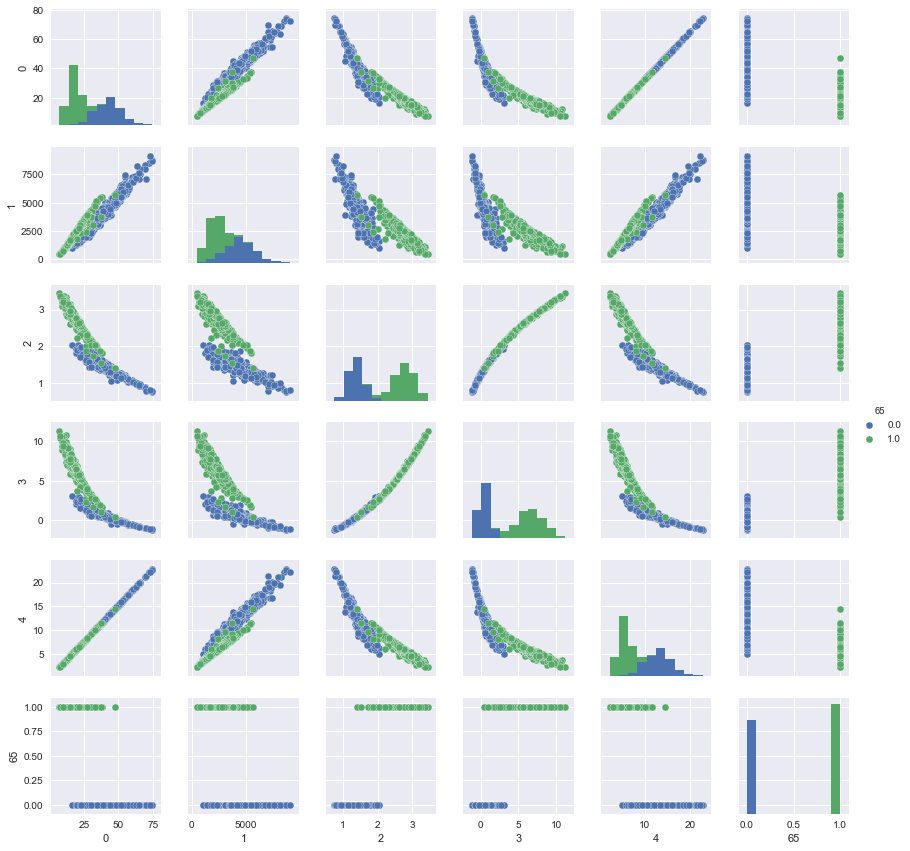

In [49]:
df_copy = df.copy()
df_zero = df.copy()[df_copy[65] == 0]

df_copy = df.copy()
df_one = df_copy[df_copy[65] == 1]
zero_and_one_df = df_zero.append(df_one, ignore_index=True)

sns.set()
sns.pairplot(zero_and_one_df,hue=65, size=2)

The plot above is a comparison between the 0 and 1 class. We can see that the distribution between 0 and 1 is different in a lot of comparisons. In some of these comparisons you can basically put a line in between the 2 different classes. For example the 1 to 3 (1 horizontal axis - 3 vertical axis) comparison can have a line going from (0,5) to (10000,0) effectively decided which class you are looking at.

The distribution difference is likely due to the fact that the numbers 0 and 1 are pretty different from each other.

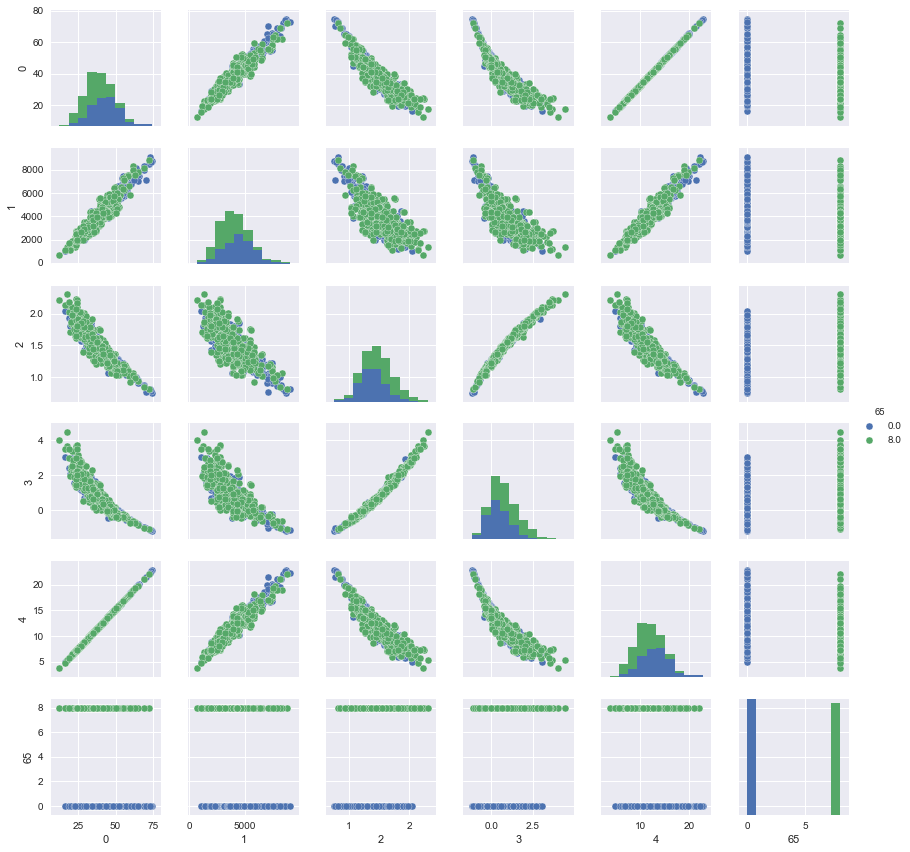

In [48]:
df_copy = df.copy()
df_eight = df.copy()[df_copy[65] == 8]
zero_and_eight_df = df_zero.append(df_eight, ignore_index=True)

sns.set()
sns.pairplot(zero_and_eight_df,hue=65, size=2)

This distribution is bit more difficult to compare the 0 and 8 target classes. With the fact that 0 and 8 are similar numbers, we get a distribution that is pretty much overlapped.

Gabor features are good for comparing certain numbers, but for comparing all the numbers as a whole this classification method isn't very effective. If we only needed to classify a certain subset of numbers this method would be fine.